In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_style('darkgrid')
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor

In [3]:
data = pd.read_csv('Bengaluru_House_Data.csv')

In [4]:
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [8]:
data.shape

(13320, 9)

In [9]:
data.isna().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [10]:
data['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [11]:
# total_sqft has some values in range and some values of str type hence we will retreive just the nums

def extract_first_part(text):
    numbers=re.findall(r'\d+\.\d+|\d+',text) # extracts all numeric parts
    return numbers[0] if numbers else None # returns the first numeric part, if present

data['total_sqft']=pd.Series(data['total_sqft']).apply(lambda x: extract_first_part(str(x)))
data=pd.DataFrame(data)

In [12]:
data['total_sqft']=pd.to_numeric(data['total_sqft'])

In [13]:
for columns in data.columns:
    print(data[columns].value_counts())
    print('-'*50)

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64
--------------------------------------------------
Ready To Move    10581
18-Dec             307
18-May             295
18-Apr             271
18-Aug             200
                 ...  
15-Aug               1
17-Jan               1
16-Nov               1
16-Jan               1
14-Jul               1
Name: availability, Length: 81, dtype: int64
--------------------------------------------------
Whitefield                        540
Sarjapur  Road                    399
Electronic City                   302
Kanakpura Road                    273
Thanisandra                       234
                                 ... 
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
singapura paradise                  1
Abshot Layout                       1
Name: location, Length: 1305, dtype:

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  float64
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(4), object(5)
memory usage: 936.7+ KB


In [15]:
# nextly we can see the size of format 2BHK, 2 bedroom etc
# hence we will trim it to 2

def extract_num(txt):
    nums = re.findall(r'\d+',txt) # extracts all digits
    return nums[0] if nums else None

data['size']=pd.Series(data['size']).apply(lambda x: extract_num(str(x)))
data=pd.DataFrame(data)

In [16]:
data['size']=pd.to_numeric(data['size'])

In [17]:
data.describe()

,size,total_sqft,bath,balcony,price
count,13304.000000,13320.000000,13247.000000,12711.000000,13320.000000
mean,2.803743,1552.950477,2.692610,1.584376,112.565627
std,1.294974,1236.591481,1.341458,0.817263,148.971674
min,1.000000,1.000000,1.000000,0.000000,8.000000
25%,2.000000,1100.000000,2.000000,1.000000,50.000000
50%,3.000000,1274.000000,2.000000,2.000000,72.000000
75%,3.000000,1675.000000,3.000000,2.000000,120.000000
max,43.000000,52272.000000,40.000000,3.000000,3600.000000


In [18]:
# next, we know that availability has various dates and objects
# our approach will be to convert it into dichotomous form (i.e., 1 - Ready to move/Immediate possession, 0 - else)

def availability_mapped(value):
    if value in ['Ready To Move','Immediate Possession']:
        return 1
    else:
        return 0

data['availability_mapped']=pd.Series(data['availability']).apply(lambda x: availability_mapped(x))
data=pd.DataFrame(data)

In [19]:
data.drop(columns='availability',axis=1,inplace=True)

In [20]:
# dropping society as it would be somewhat irrelevant and also it has more tham 30% null values 
data.drop(columns='society',axis=1,inplace=True)

In [21]:
data.isna().sum()

area_type                0
location                 1
size                    16
total_sqft               0
bath                    73
balcony                609
price                    0
availability_mapped      0
dtype: int64

In [22]:
data.dropna(axis=0,inplace=True)

In [23]:
data.shape

(12710, 8)

Text(0.5, 1.0, 'Boxplot of numeric columns')

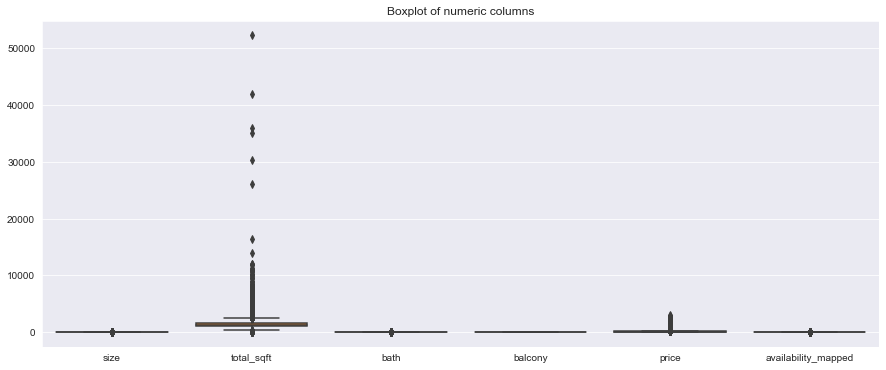

In [24]:
plt.figure(figsize=(15,6))
sns.boxplot(data=data)
plt.title('Boxplot of numeric columns')

In [25]:
data

,area_type,location,size,total_sqft,bath,balcony,price,availability_mapped
0,Super built-up Area,Electronic City Phase II,2.0,1056.0,2.0,1.0,39.07,0
1,Plot Area,Chikka Tirupathi,4.0,2600.0,5.0,3.0,120.00,1
2,Built-up Area,Uttarahalli,3.0,1440.0,2.0,3.0,62.00,1
3,Super built-up Area,Lingadheeranahalli,3.0,1521.0,3.0,1.0,95.00,1
4,Super built-up Area,Kothanur,2.0,1200.0,2.0,1.0,51.00,1
...,...,...,...,...,...,...,...,...
13314,Super built-up Area,Green Glen Layout,3.0,1715.0,3.0,3.0,112.00,1
13315,Built-up Area,Whitefield,5.0,3453.0,4.0,0.0,231.00,1
13317,Built-up Area,Raja Rajeshwari Nagar,2.0,1141.0,2.0,1.0,60.00,1
13318,Super built-up Area,Padmanabhanagar,4.0,4689.0,4.0,1.0,488.00,0


In [42]:
data['availability_mapped'].describe()

count    12710.000000
mean         0.792840
std          0.405287
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: availability_mapped, dtype: float64

In [30]:
locations = data['location'].value_counts()

In [33]:
top_10 = locations.head(20)

In [34]:
top_10

Whitefield                  514
Sarjapur  Road              372
Electronic City             300
Kanakpura Road              261
Thanisandra                 231
Yelahanka                   206
Uttarahalli                 186
Hebbal                      173
Raja Rajeshwari Nagar       168
Marathahalli                164
7th Phase JP Nagar          147
Bannerghatta Road           144
Hennur Road                 142
Haralur Road                135
Electronic City Phase II    130
Rajaji Nagar                 99
Chandapura                   98
Bellandur                    91
Electronics City Phase 1     86
Hoodi                        86
Name: location, dtype: int64

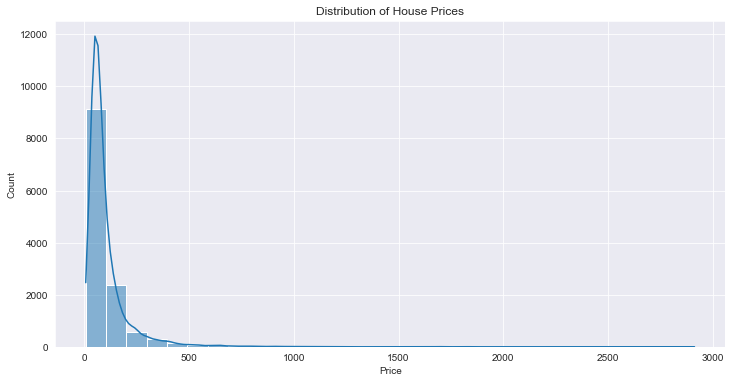

In [22]:
# Univariate analysis
# Histogram for target variable

plt.figure(figsize=(12, 6))
sns.histplot(data['price'], bins=30, kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.show()

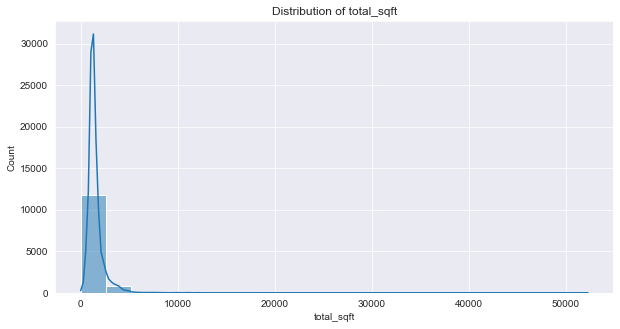

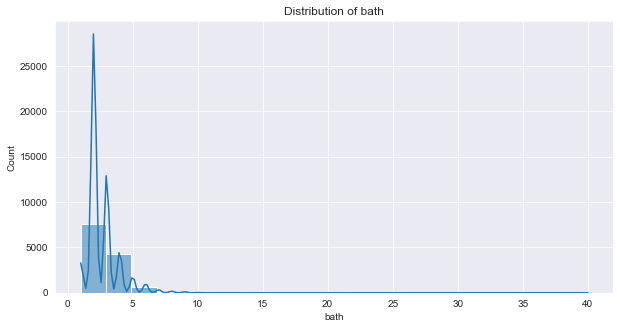

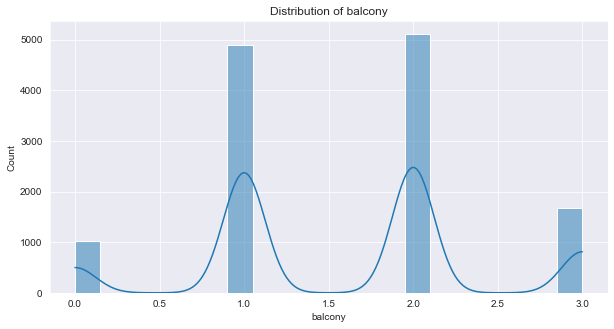

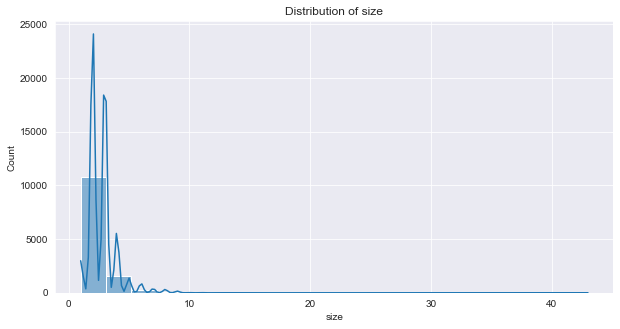

In [23]:
# Univariate Analysis - Histograms for numerical features
numerical_features = ['total_sqft', 'bath', 'balcony','size']
for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(data[feature], bins=20, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.show()

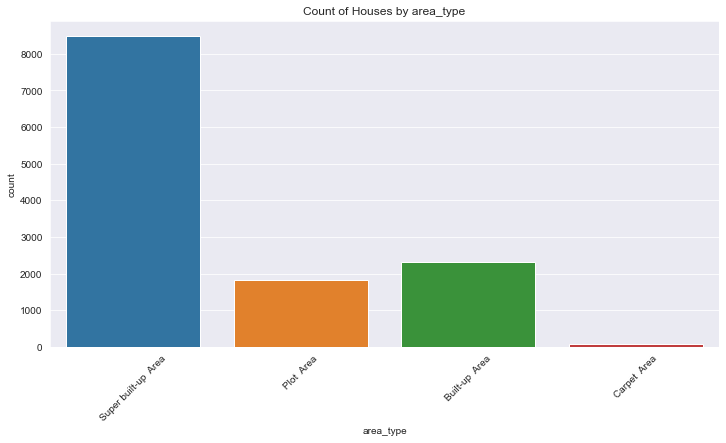

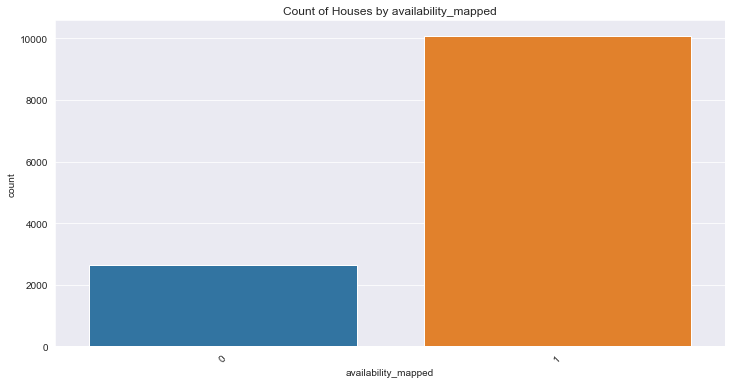

In [24]:
# Univariate Analysis - Bar plots for categorical features
categorical_features = ['area_type', 'availability_mapped']
for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=feature, data=data)
    plt.title(f'Count of Houses by {feature}')
    plt.xlabel(feature)
    plt.xticks(rotation=45)
    plt.show()

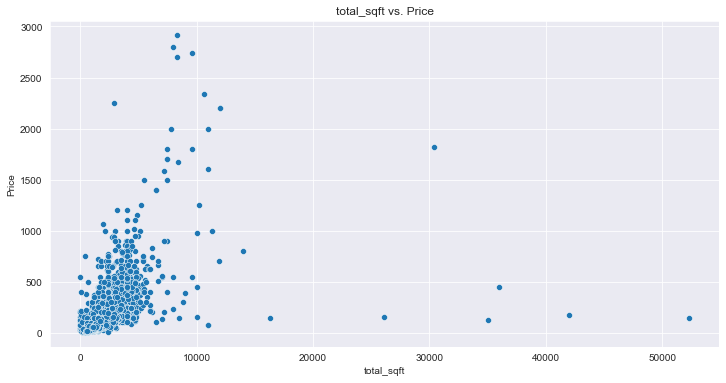

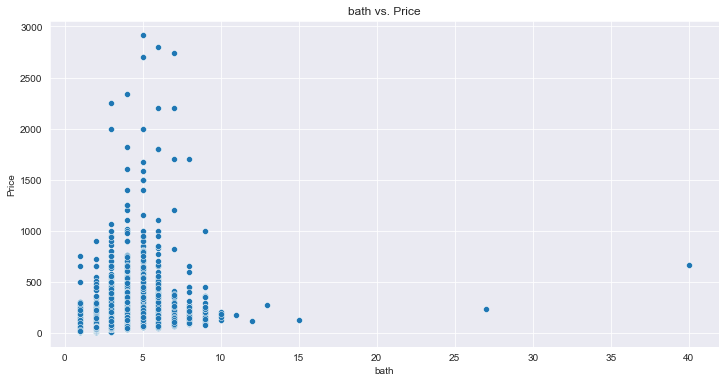

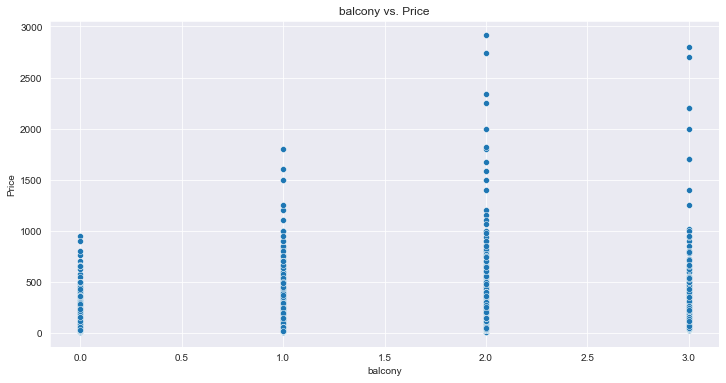

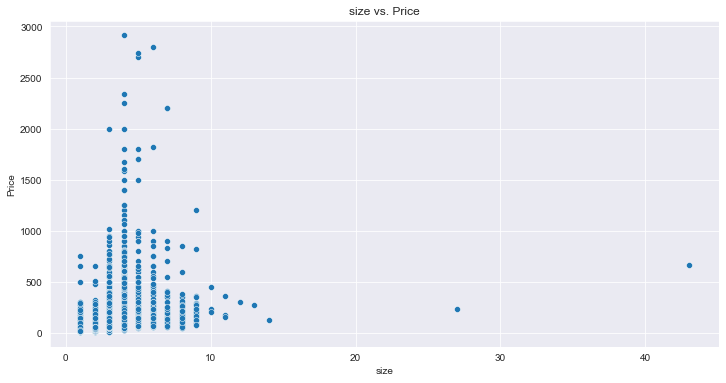

In [25]:
# Bivariate Analysis - Scatter plots for numerical features vs. 'price'
for feature in numerical_features:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=feature, y='price', data=data)
    plt.title(f'{feature} vs. Price')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.show()

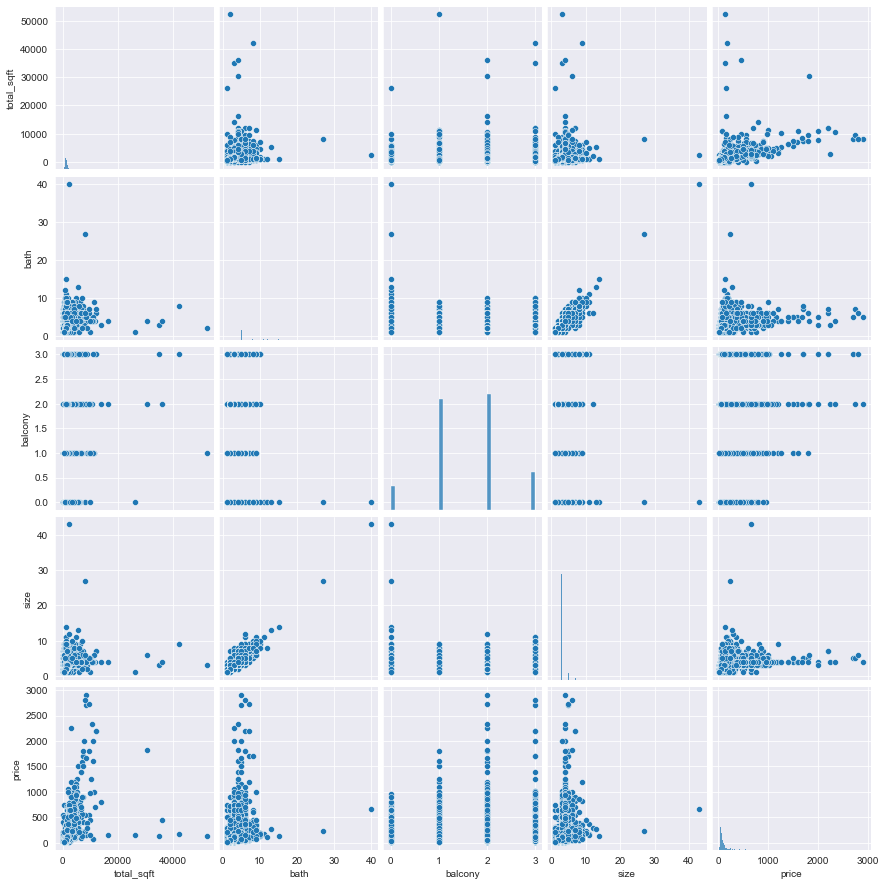

In [26]:
# Multivariate Analysis - Pair plot for numerical features
sns.pairplot(data[numerical_features + ['price']])
plt.show()

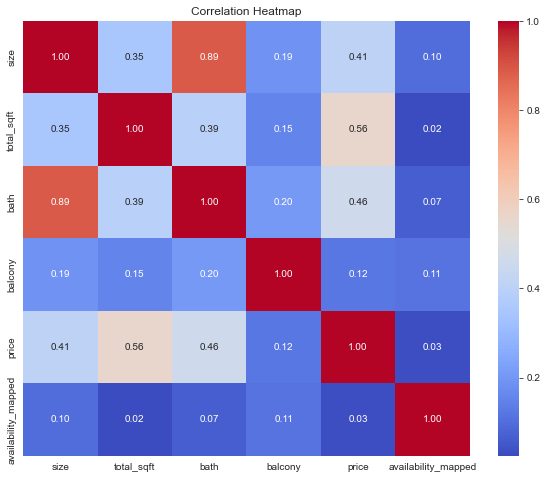

In [27]:
# Correlation heatmap
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Preprocessing

<AxesSubplot:>

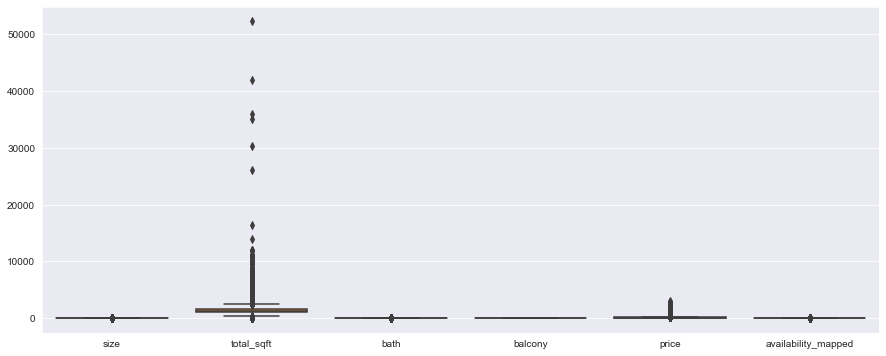

In [28]:
plt.figure(figsize=(15,6))
sns.boxplot(data=data)

In [29]:
data

,area_type,location,size,total_sqft,bath,balcony,price,availability_mapped
0,Super built-up Area,Electronic City Phase II,2.0,1056.0,2.0,1.0,39.07,0
1,Plot Area,Chikka Tirupathi,4.0,2600.0,5.0,3.0,120.00,1
2,Built-up Area,Uttarahalli,3.0,1440.0,2.0,3.0,62.00,1
3,Super built-up Area,Lingadheeranahalli,3.0,1521.0,3.0,1.0,95.00,1
4,Super built-up Area,Kothanur,2.0,1200.0,2.0,1.0,51.00,1
...,...,...,...,...,...,...,...,...
13314,Super built-up Area,Green Glen Layout,3.0,1715.0,3.0,3.0,112.00,1
13315,Built-up Area,Whitefield,5.0,3453.0,4.0,0.0,231.00,1
13317,Built-up Area,Raja Rajeshwari Nagar,2.0,1141.0,2.0,1.0,60.00,1
13318,Super built-up Area,Padmanabhanagar,4.0,4689.0,4.0,1.0,488.00,0


In [30]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

In [31]:
train.to_csv('train_set.csv',index=False)
test.to_csv('test_set.csv',index=False)

In [32]:
X_train = train.drop(columns='price',axis=1)
y_train = train['price']

In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9532 entries, 5622 to 7648
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   area_type            9532 non-null   object 
 1   location             9532 non-null   object 
 2   size                 9532 non-null   float64
 3   total_sqft           9532 non-null   float64
 4   bath                 9532 non-null   float64
 5   balcony              9532 non-null   float64
 6   availability_mapped  9532 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 595.8+ KB


In [34]:
numerical_features = X_train.select_dtypes(include='number').columns
categorical_features = X_train.select_dtypes(include='object').columns

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [36]:
numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

In [37]:
categoric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('OHE',OneHotEncoder(handle_unknown='ignore'))
])

In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num',numeric_transformer, numerical_features),
        ('cat',categoric_transformer, categorical_features)
    ]
)

In [39]:
pre = Pipeline(steps=[('preprocessor',preprocessor)])

In [40]:
pre.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['size', 'total_sqft', 'bath', 'balcony', 'availability_mapped'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OHE',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['area_type', 'location'], dtype='object'))]))])

In [41]:
import pickle

In [42]:
with open('preprocessed.pkl','wb') as f:
    pickle.dump(pre, f)